# Welcome to ibicus!

## 1. Introduction

Ibicus is a python software package that helps you apply, compare and evaluate a range of different bias adjustment methods. This notebook guides you through the workflow of bias adjusting the variable 'tas' (2m surface temperature) using ibicus. The notebook is ideal if you are new to bias adjustment and want to familiarize yourself with the different steps.

**Requirements for starting this notebook**

- Have some testing data ready. You can either use the data we provide and download (see below) or downloaded and pre-processed your own testing data. 
- Have ibicus installed. Just use: ``pip install ibicus``


**Link to other notebooks and documentation pages**
- If you want to download and pre-process observational and climate model testing data first, start with this [00 Download and Preprocess](https://nbviewer.org/github/ecmwf-projects/ibicus/blob/main/notebooks/00%20Download%20and%20Preprocess.ipynb).
- For an introduction to the idea and general methodology of bias adjustment, have a look at this page: [What is bias adjustment?](https://ibicus.readthedocs.io/en/latest/getting_started/whatisdebiasing.html)
- [02 Adjusting Debiasers](https://nbviewer.org/github/ecmwf-projects/ibicus/blob/main/notebooks/02%20Adjusting%20Debiasers.ipynb) gives a more advanced overview of how to initialize apply different debiasers and the choices the user can make.
- For a detailed overview of evaluation methods available, have a look at the evaluation notebook [03 Evaluation](https://nbviewer.org/github/ecmwf-projects/ibicus/blob/main/notebooks/03%20Evaluation.ipynb).
- If you want to use ibicus for larger projects or in high performance computing environments have a look at [04 Parallelization and Dask](https://nbviewer.org/github/ecmwf-projects/ibicus/blob/main/notebooks/04%20Parallelization%20and%20Dask.ipynb).

## 2. Load pre-processed testing data

To bias adjust climate model values ibicus always requires three datasets of the same climatic variable:

- obs: observational data (usually a reanalysis) over a historical or reference period. 
- cm_hist: climate model values in a historical or reference period (same period as obs).
- cm_future: climate model values to debias, usually climate model values in a future period.

obs and cm_hist are used to construct an empirical transfer function between simulated and observed distribution of the climatic variable. This transfer function is then applied to cm_future to debias it.

We provide some testing data inside the [ibicus GitHub repo](https://github.com/ecmwf-projects/ibicus). We can download and unpack it:

In [ ]:
!wget https://github.com/ecmwf-projects/ibicus/blob/main/notebooks/testing_data.zip -c
!unzip testing_data.zip

The testing data was already preprocessed. It containts data from an historical and future simulation of a climate model as well as reanalysis data serving as observations. Necessary preprocessing steps that were applied:

1. Regridding the datasets to the same area and grid in space and time.
2. Conducted checks for corrupted or missing data.

ibicus works on numpy arrays of data of the form: ``[t, x, y]`` (first dimension corresponds to timesteps and then come the two spatial dimensions). From the regridded data we therefore extracted the data arrays. Additionally we extracted the time information, as this can be required by some debiasers. 

We can read in the data:

In [1]:
import numpy as np

def get_data(variable, data_path = "testing_data/"):
    # Load in the data 
    data = np.load(f"{data_path}{variable}.npz", allow_pickle = True)
    # Return arrays
    return data["obs"], data["cm_hist"], data["cm_future"], data["time_obs"], data["time_cm_hist"], data["time_cm_future"]

In [2]:
tas_obs, tas_cm_hist, tas_cm_future, time_obs, time_cm_hist, time_cm_future = get_data(variable = 'tas')

``tas_obs``, ``tas_cm_hist`` and ``tas_cm_future`` now contain observations as well as historical and future climate model data for ``tas``. Additionally the times corresponding to each timestep are stored in ``time_obs``, ``time_cm_hist`` and ``time_cm_future``.

## 3. Initialize the bias adjustment method

We are going to initialize two debiasers that we can later apply to our testing data: 
- ``LinearScaling``, a simple bias adjustment method that corrects the mean of the climate model.
- ``ISIMIP``, a trend-preserving parametric quantile mapping method, explained in detail in the class documentation.

Both of them are child classes of the more general Debiaser class and contain the core calculations necessary for each bias adjustment method. Let's import the two:

In [3]:
from ibicus.debias import LinearScaling, ISIMIP

Even though the two debiasers have very different degrees of complexity, they can both be initialized in a similarly simple manner using the ``from_variable`` classmethod and by specifying the variable you wish to debias. This initializes a set of default settings in both debiasers. These default settings can of course be manually overwritten, as described in detail in the notebook 02 Adjusting Debiasers.

**Linear Scaling:**

In [4]:
tas_debiaser_LS = LinearScaling.from_variable(variable = 'tas')

**ISIMIP:**

In [5]:
tas_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tas')

## 4. Applying the bias adjustment method on the validation period

In order to evaluate the performance of different bias adjustment methods, before choosing the one to use for the future application period, it is useful to split the historical data (both climate model and observations) into a training and a validation period. Using the training period we can then debias the historical climate model over the validation period and compare it with observations in this period. Let's split the data:

In [6]:
split_ratio = 0.7
split = int(split_ratio * tas_obs.shape[0])

# First split observations
tas_obs_train = tas_obs[ :split]
tas_obs_val = tas_obs[split: ]
time_obs_train = time_obs[ :split]
time_obs_val = time_obs[split: ]

# Then split cm_hist
tas_cm_hist_train = tas_cm_hist[ :split]
tas_cm_hist_val = tas_cm_hist[split: ]
time_cm_hist_train = time_cm_hist[ :split]
time_cm_hist_val = time_cm_hist[split: ]

And run the initialised debiasers on the train and validation period:

**Linear Scaling:**

In [7]:
tas_val_debiased_LS = tas_debiaser_LS.apply(tas_obs_train, tas_cm_hist_train, tas_cm_hist_val)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|█████████████████████████████████████████| 225/225 [00:00<00:00, 5823.27it/s]


**ISIMIP:**

In [8]:
tas_val_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs_train, tas_cm_hist_train, tas_cm_hist_val, time_obs = time_obs_train, time_cm_hist = time_cm_hist_train, time_cm_future = time_cm_hist_val)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|███████████████████████████████████████████| 225/225 [28:40<00:00,  7.65s/it]


## 5. Evaluating the bias corrected climate model on the validation period

After running the debiasers above we have now debiased climate model data in a validation period. We can compare this with observations in the same period to see whether the method has actually improved the bias of the climate model compared to observations.

The ``ThresholdMetrics`` class in the ``ibicus.metrics`` module provides the functionality to define targeted metrics associated with each variable. In this tutorial, we will simply investigate the occurrence of 'mean warm days' and 'mean cold days'. We can import those:

In [9]:
from ibicus.evaluate.metrics import warm_days, cold_days
tas_metrics = [warm_days, cold_days]

We also import the marginal module, which contains all functions to conduct a location-wise evaluation.

In [10]:
from ibicus.evaluate import marginal

The following function provides an entry point into evaluating the performance of the bias adjustment method. It calculates the bias of the mean, 5th percentile and 95th percentile of the climate model with respect to observations by default, as well as the bias of the additional metrics specified above.

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/marginal.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias = 100 * (obs_metric - cm_metric) / obs_metric
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/marginal.py:54: RuntimeWarning: divide by zero encountered in true_divide
  bias = 100 * (obs_metric - cm_metric) / obs_metric
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_59717/3289275602.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


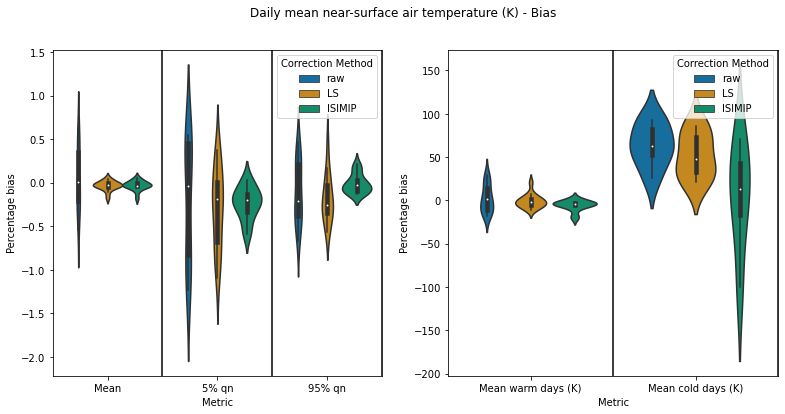

In [11]:
tas_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tas_metrics, obs_data = tas_obs_val,
                                                          raw = tas_cm_hist_val, LS = tas_val_debiased_LS,
                                                          ISIMIP = tas_val_debiased_ISIMIP, remove_outliers = False)

plot = marginal.plot_marginal_bias(variable = 'tas', bias_df = tas_marginal_bias_data)
plot.show()

## 6. Apply the debiaser to the future period

Based on some evalution we can now decide to apply the debiaser onto the future period -- the one we want to debias. This can be done as follows:

In [12]:
tas_fut_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_future, time_obs = time_obs, time_cm_hist = time_cm_hist, time_cm_future = time_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|███████████████████████████████████████████| 225/225 [11:05<00:00,  2.96s/it]


The variable tas_fut_debiased_ISIMIP now contains the bias corrected climate model data for the period 2065-2100. Congratulations!